In [1]:
import pandas as pd
import numpy as np 
import sys

import geopandas as gpd
import shapely
import fiona
import folium

import seaborn as sns
import matplotlib.pyplot as plt

# sys.path.insert(0,'Repos/newcastle/air-quality/src/')
sys.path.insert(0,'../src')
from v0 import *

## Dataset

In [133]:
SHAPE_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/shape/Middle_Layer_Super_Output_Areas_December_2011_Full_Extent_Boundaries_in_England_and_Wales/'
DATA_FOLDER = '/home/adelsondias/Repos/newcastle/air-quality/data_allsensors_8days/'
metadata, sfeat, sensors = load_data(SHAPE_FOLDER, DATA_FOLDER)

variables =  {
        'sensors':['NO2','Temperature','Humidity','O3','CO','PM10'],
        'exogenous':['primary','trunk','motorway','signals','day','dow','hour'] #'street' = 'primary','trunk','motorway','traffic_signals'
}
sensors, metadata = resampling_sensors(sensors, metadata, variables, 'H')

## 1. Feature ingestion

This consider a list of k neighbors measures for each time and variable, to predict a single target specified

In [ ]:
variables = {
    'sensors':['NO2','Temperature','O3','CO','PM10'],
    'exogenous':['primary','trunk','motorway','traffic_signals','hour']
}

zx, zi = ingestion(sensors, metadata, sfeat, variables, k=5, target='NO2', method='randomized')
print(zx.shape,zi.shape)
zx.head()

In [22]:
if False: # save
    zx.to_csv(DATA_FOLDER+'zx_D_7days.csv')
    zi.to_csv(DATA_FOLDER+'zi_D_7days.csv')
if False: # load
    zx = pd.read_csv(DATA_FOLDER+'zx_D_7days.csv',index_col=['Sensor Name','Timestamp'])
    zi = pd.read_csv(DATA_FOLDER+'zi_D_7days.csv',index_col=['Sensor Name','Timestamp'])

### 1.a. Inverse Distance Weighting

In [ ]:
def iwd_features(zx, sensor_variables):
    ziwd = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        ziwd['iwd_{}'.format(var)] = (((zx['d_{}'.format(var)].values*zx[var].values).sum(axis=1))/zx['d_{}'.format(var)].values.sum(axis=1))
    return ziwd
ziwd = iwd_features(zx, variables['sensors'])
ziwd = ziwd.join(zx[variables['exogenous']])
ziwd.head()

### 1.b. Spatial Averaging

In [40]:
def spavg_features(zx, sensor_variables):
    zavg = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        zavg['spavg_{}'.format(var)] = zx[var].values.sum(axis=1)/zx[var].shape[1]
    return zavg   
zavg = spavg_features(zx, variables['sensors'])
zavg = zavg.join(zx[variables['exogenous']])

### 1.b. Nearest Neighbor

In [63]:
def nn_features(zx, sensor_variables):
    znn = pd.DataFrame(index=zx.index)
    for var in sensor_variables:
        znn['nn_{}'.format(var)] = zx[['d_{}'.format(var),var]].apply(lambda x: x[var].values[x['d_{}'.format(var)].values.argmin()], axis=1)
    return znn
znn = nn_features(zx, variables['sensors'])
znn = znn.join(zx[variables['exogenous']])

### Feature correlation visualization

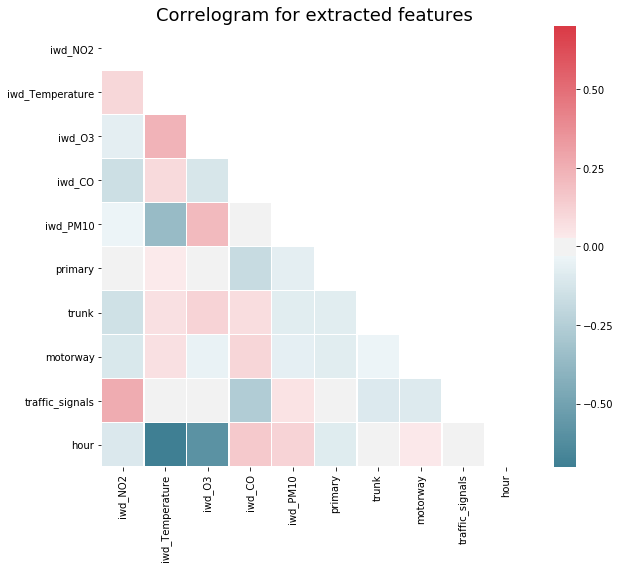

In [14]:
def corrplot(zx):
    corr = zx.convert_objects(convert_numeric=True).corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(9,8));
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, vmin=-.7,linewidths=.5, ax=axes)
    plt.title('Correlogram for extracted features', fontsize=18)
    plt.tight_layout()
#     plt.savefig(DATA_FOLDER+'plots/correlogram_general.svg', format='svg', dpi=600)
corrplot(ziwd)

## Regression example

Random Forest

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

paramsrf = {
    'n_estimators':np.arange(5,300,15),
    'max_features':np.arange(0.1, 1.01, 0.05),
    'max_depth':np.arange(1,20,2)
}
grid = RandomizedSearchCV(rf, param_distributions=paramsrf,
                    n_iter=10, scoring='r2', n_jobs=-1, cv=5).fit(zx.values, np.ravel(zi.values))
grid.best_score_

-2.3983578229980704

MultiLayer Perceptron

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e89470f28>]],
      dtype=object)

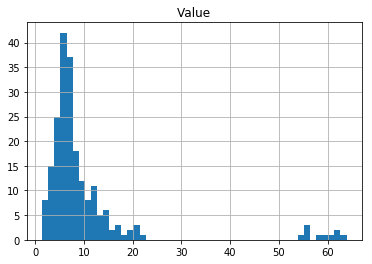

In [136]:
ix = zi[(zi['Value'] < 100) & (zi['Value'] > 15)].index
ziwd2 = ziwd.loc[ix]
zi2 = zi.loc[ix]
zi2.hist(bins=100)

In [ ]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(max_iter=1000000, tol=1e-7, solver='sgd', learning_rate='adaptive', early_stopping=True)

paramsmlp = {
    'hidden_layer_sizes':[(10,5,5),(15,10,10),(10,5,5,2),(30,20,20,10),(50,30,20,10)],
    'activation':['relu'],
    'alpha':np.linspace(0.000001,0.01,100)
}
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer

# ziwd.head() # ['iwd_NO2','traffic_signals','hour']
ix = zi[(zi['Value'] < 100) & (zi['Value'] > 1)].index
ziwd2 = ziwd.loc[ix]
zi2 = zi.loc[ix]

grid = RandomizedSearchCV(mlp, param_distributions=paramsmlp,
                    n_iter=100, scoring='r2', n_jobs=-1, cv=3).fit(MinMaxScaler().fit_transform(ziwd2), MinMaxScaler().fit_transform(zi2))
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.cv_results_['mean_train_score'][:10])
print(grid.cv_results_['mean_test_score'][:10])

## Feature importance analysis

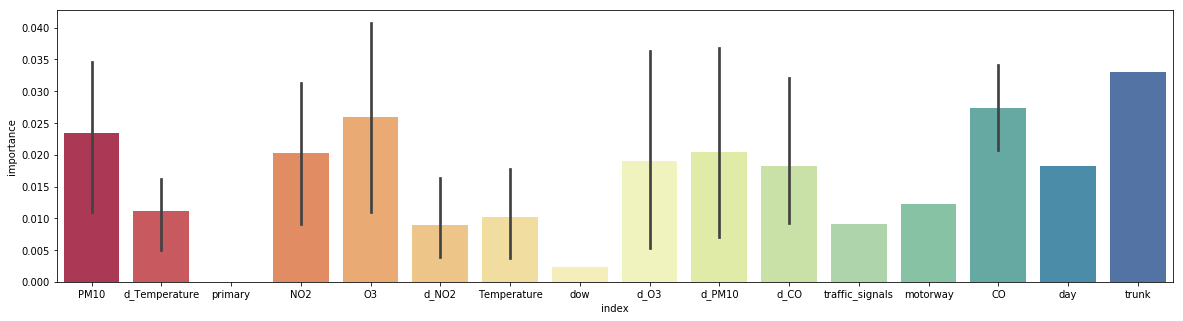

In [76]:
def feature_importance_plot(grid, zx):
    importances = grid.best_estimator_.feature_importances_
    indices = zx.columns[np.argsort(importances)[::-1]]
    f = pd.DataFrame(importances, index=indices, columns=['importance']).reset_index().sort_values('importance')

    plt.figure(figsize=(20,5))
    return sns.barplot(x='index',y='importance',data=f, palette='Spectral')
feature_importance_plot(grid,zx)